### 1. Import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,b_piece_activity,w_doubled_pawns,b_doubled_pawns,doubled_pawns_diff,w_isolated_pawns,b_isolated_pawns,isolated_pawns_diff,both_castled_early,total_captures_early,activity_diff
0,2404,2534,0,0,130,2469.0,0,-130,0,20.0,...,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11.0,1.0
1,2752,2395,2,0,357,2573.5,1,357,0,16.0,...,27.0,0.0,0.0,0.0,3.0,1.0,2.0,0,18.0,0.0
2,2558,2685,2,0,127,2621.5,0,-127,1,22.0,...,32.0,0.0,0.0,0.0,0.0,1.0,-1.0,0,14.0,-2.0
3,2514,2351,0,0,163,2432.5,1,163,0,6.0,...,23.0,0.0,0.0,0.0,0.0,1.0,-1.0,0,20.0,-2.0
4,2582,2494,2,0,88,2538.0,1,88,0,18.0,...,41.0,1.0,0.0,1.0,4.0,0.0,4.0,0,17.0,-6.0


### 2. Prepare data

In [3]:
X = df.drop('ResultNumeric', axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (1686173, 54)
Target: (1686173,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

#### Scale feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver='saga',
    random_state=42,
    n_jobs=-1,
)

In [7]:
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 27.28 seconds (0.45 minutes)


### 5. Evaluate

In [8]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report: \n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))

Accuracy: 0.6182 (61.82%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.61      0.68      0.64    132965
        Draw       0.66      0.29      0.40     64732
   White Win       0.62      0.71      0.66    139538

    accuracy                           0.62    337235
   macro avg       0.63      0.56      0.57    337235
weighted avg       0.62      0.62      0.60    337235



### 6. Confusion Matrix

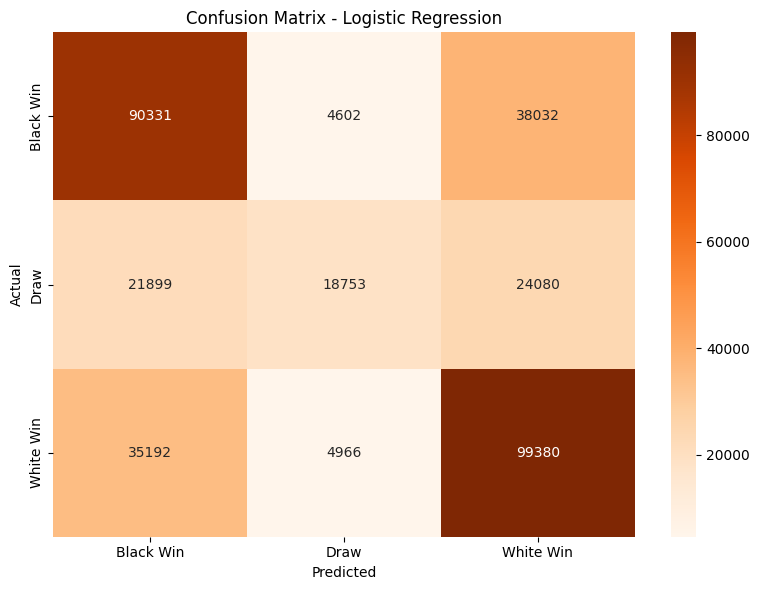

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

### 7. Coefficients (Feature importance for linear models)

                  Feature  Coefficient
6    WhiteRatingAdvantage     0.187447
10    material_diff_early     0.159495
0                WhiteElo     0.130320
1                BlackElo     0.129778
4               AvgRating     0.116029
2             EventTypeID     0.094521
28     capture_diff_early     0.073280
3              RatingDiff     0.070949
25             queen_diff     0.064132
53          activity_diff     0.056680
22              rook_diff     0.054275
8        w_material_early     0.048172
9        b_material_early     0.044578
44       b_piece_activity     0.038884
26       w_captures_early     0.037241
43       w_piece_activity     0.036121
27       b_captures_early     0.035622
21                b_rooks     0.033202
20                w_rooks     0.033131
31  aggression_diff_early     0.030185
5      WhiteIsHigherRated     0.027843
16            knight_diff     0.027788
15              b_knights     0.026793
14              w_knights     0.026265
19            bishop_diff

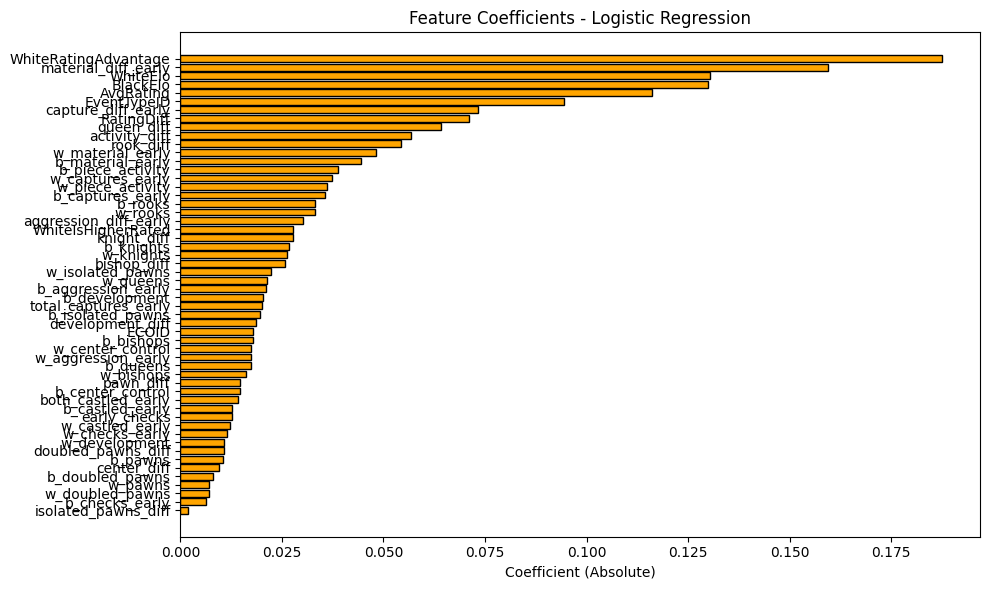

In [10]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lr_model.coef_).mean(axis=0)  # Average across classes
}).sort_values('Coefficient', ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], 
         color='orange', edgecolor='black')
plt.xlabel('Coefficient (Absolute)')
plt.title('Feature Coefficients - Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()